In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
from arcs.generate import GraphGenerator

In [24]:
graph = GraphGenerator().from_file(filename='../tests/test_dft_data.json',temperature=100,pressure=1)

/Users/badw/github-projects/arcs/arcs/setup_functions.py:256: RuntimeWarning: overflow encountered in exp
  K = np.exp(


In [ ]:
{
    '<compound>': {
        'atoms': 'ase.Atoms.asdict()',
        'pointgroup': '<pointgroup>',
        'spin': '<spin>',
        'rotation_num': '<rotation_num>',
        'islinear': '<islinear>',
        'energy': '<energy>',
        'vibrations': '<vibrations'
    }
    'reactions':list({
        'reaction_string':'<reaction_string>',
                      'reactants':'dict(reactants)',
                      'products':'dict(products)'}
                      )
}

In [25]:
d = loadfn('../tests/test_dft_data.json')
d['CO2']

{'atoms': {'numbers': array([6, 8, 8]),
  'positions': array([[ 9.99999995, 10.0000001 , 10.00000005],
         [10.00000026, 10.00000003, 11.16339959],
         [ 9.9999998 ,  9.99999987,  8.83660036]]),
  'initial_magmoms': array([0., 0., 0.]),
  'cell': array([[20.,  0.,  0.],
         [ 0., 20.,  0.],
         [ 0.,  0., 20.]]),
  'pbc': array([ True,  True,  True])},
 'pointgroup': 'D*h',
 'spin': 0,
 'rotation_num': 2,
 'islinear': 'linear',
 'energy': -32.14142067,
 'vibrations': [0.304959975,
  0.172201086,
  0.083915672,
  0.082816263,
  0.003106681,
  0.002545827]}

/Users/badw/miniconda3/envs/py311/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  node_collection = ax.scatter(


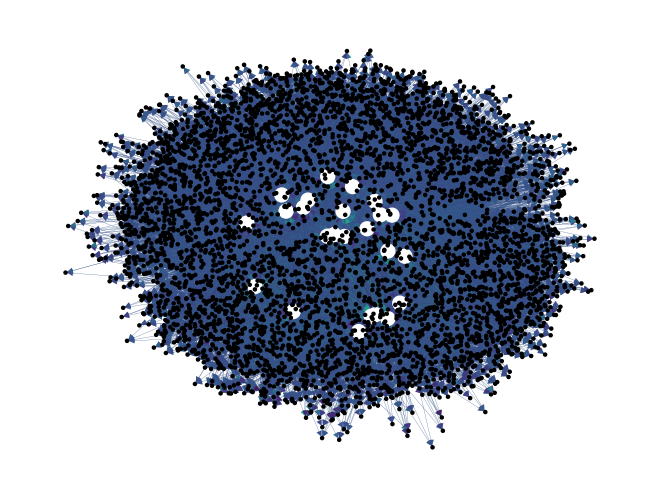

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx 
import numpy as np 
G = graph 

node_colours= []
node_sizes = []
for node in list(G.nodes):
    if isinstance(node,int):
        node_colours.append('black')
        node_sizes.append(5)
    else:
        node_colours.append('white')
        node_sizes.append(100)

edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
vmin = np.min(weights)
vmax = np.max(weights)
cmap = plt.cm.viridis

nx.draw_random(G,node_color=node_colours,node_size=node_sizes,edgelist=edges,edge_color=weights,width=0.1,edge_cmap=cmap,vmin=vmin,vmax=vmax)